В данном проекте удалось реализовать дообучающуюся модель, а также установить и запустить все необходимые интсрументы мониторинга (graphite, graphana, node_exporter, prometheus).
Однако, отправить метрику в graphite и тем более через node exporter в promethteus не удалось, несмотря на попытки решить вопрос в Slack.


### 1. Preparing the wine-quality prediction model

In [96]:
#Importing required packages.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
%matplotlib inline

# Ignoring Unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score
import joblib
import pandas as pd
import numpy as np
RANDOM_SEED = 42

In [74]:
df = pd.read_csv('winequality-red.csv', sep=';')

In [75]:
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [76]:
df.shape

(1599, 12)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [78]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [79]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [80]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [81]:
ncols = ['fixed acidity', 'volatile acidity', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'pH','total sulfur dioxide',
       'sulphates', 'alcohol']

#### Let's examine the 'quality' column distribution and split it into 'good' and 'bad' classes

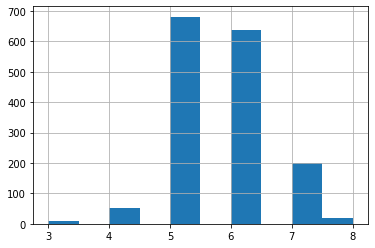

In [82]:
df['quality'].hist()

In [83]:
# Consider quality 'good' if higher than 6 else 'bad'
df['quality'] = df['quality'].apply(lambda x: 1 if x>6 else 0)

In [84]:
df['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

In [85]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


#### Let's separate into training and testing set

In [86]:

X_train, X_test, y_train, y_test = train_test_split(df.drop('quality', axis=1),
                                                    df['quality'],
                                                    test_size=0.3,
                                                    random_state=0)

X_train.shape, X_test.shape

((1119, 11), (480, 11))

#### The Catboostclassifier model is one of my favorite ML models and it shows good results here again

In [97]:
def get_catboostclassifer_model(df, num_cols):

    y = df['quality']
    X = df[num_cols]
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.20, random_state=RANDOM_SEED, shuffle=True, stratify = y)
    cbc = CatBoostClassifier(n_estimators=1000, random_seed=RANDOM_SEED)
    cbc.fit(X_train, y_train,
             eval_set=[(X_train, y_train),
                       (X_valid, y_valid)],
             early_stopping_rounds=1000,
             verbose_eval=100,
             use_best_model=True)
    y_pred = cbc.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    print(cbc.get_best_score())
    return y_pred,y_valid,acc
     
y_pred,y_valid,acc = get_catboostclassifer_model(df,ncols)   



Learning rate set to 0.033675
0:	learn: 0.6538118	test: 0.6538118	test1: 0.6524450	best: 0.6524450 (0)	total: 2.18ms	remaining: 2.17s
100:	learn: 0.1941694	test: 0.1941694	test1: 0.2112946	best: 0.2112946 (100)	total: 222ms	remaining: 1.98s
200:	learn: 0.1429035	test: 0.1429035	test1: 0.1918325	best: 0.1918325 (200)	total: 433ms	remaining: 1.72s
300:	learn: 0.1085924	test: 0.1085924	test1: 0.1893394	best: 0.1876000 (274)	total: 648ms	remaining: 1.5s
400:	learn: 0.0825222	test: 0.0825222	test1: 0.1871606	best: 0.1862417 (366)	total: 859ms	remaining: 1.28s
500:	learn: 0.0621226	test: 0.0621226	test1: 0.1828669	best: 0.1828669 (500)	total: 1.12s	remaining: 1.11s
600:	learn: 0.0476674	test: 0.0476674	test1: 0.1808225	best: 0.1796700 (574)	total: 1.38s	remaining: 915ms
700:	learn: 0.0370640	test: 0.0370640	test1: 0.1789079	best: 0.1777696 (676)	total: 1.61s	remaining: 689ms
800:	learn: 0.0298717	test: 0.0298717	test1: 0.1809889	best: 0.1777696 (676)	total: 1.85s	remaining: 460ms
900:	learn:

In [98]:
print("Accuracy Score:",accuracy_score(y_pred,y_valid))
print("classification Report:\n",classification_report(y_pred,y_valid))

Accuracy Score: 0.94375
classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       285
           1       0.70      0.86      0.77        35

    accuracy                           0.94       320
   macro avg       0.84      0.91      0.87       320
weighted avg       0.95      0.94      0.95       320



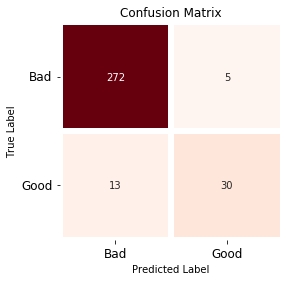

In [99]:
cm = confusion_matrix(y_valid, y_pred)

df1 = pd.DataFrame(columns=["Bad","Good"], index= ["Bad","Good"], data= cm )

f,ax = plt.subplots(figsize=(4,4))

sns.heatmap(df1, annot=True,cmap="Reds", fmt= '.0f',ax=ax,linewidths = 5, cbar = False)
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()

### Incremental training

In [100]:
def streaming_reading(X_train, y_train, batch_size=0.5*len(y_train)):
    X = []
    y = []
    current_line = 0
    train_data, train_label = shuffle(X_train, y_train, random_state=42)
    train_data = train_data.to_numpy()
    for row, target in zip(train_data, train_label):
        X.append(row)
        y.append(target)

        current_line += 1
        if current_line >= batch_size:
            X, y = np.array(X), np.array(y)
            print (y.shape,batch_size)
            yield X, y
            X, y = [], []
            current_line = 0

#### Using the CatBoostClassifier model

In [114]:
def sending_score(score_):
    # Отправка метрики в Graphite. 
    # Решить проблему передачи метрики в graphite не удалось. 
    # P.S.(обсуждалось в Slack в личной переписке с Леонидом К.)
    # Также не удалось получить метрики от node_exporter в prometheus (вопрос поднимался в канале ml-06_prod-3)
    # Поэтому предлагаю непротестированное решение здесь:
    s = str(round(score_,3))
    os.system(f'echo "skillfactory.tutorial.accuracy_score {s} `date +%s`" | nc localhost 2003')
    return

def Incremental_CBC(X, y):  
    
    RANDOM_SEED = 42
    cbc = CatBoostClassifier(n_estimators=1000, random_seed=RANDOM_SEED)
    streaming_train_iterators = streaming_reading(X, y, batch_size=620)
  
    for i, data in enumerate(streaming_train_iterators):
        X_batch = data[0]
        y_batch = data[1]
        X_train, X_valid, y_train, y_valid = train_test_split(X_batch, y_batch, test_size=0.1, random_state=RANDOM_SEED,shuffle=True, stratify = y_batch)
        y_train = y_train.ravel()
        
        if i<1:
            model_ = None
        else:
            model_ = cbc
            
        cbc.fit(X_train, y_train,
                 init_model=model_,
             eval_set=[(X_train, y_train),
                       (X_valid, y_valid)],
             early_stopping_rounds=1000,
             verbose = False,#verbose_eval=1000,
             use_best_model=True)
        y_pred = cbc.predict(X_valid)
        acc = accuracy_score(y_valid, y_pred)
        sending_score(acc)
        print(f"Accuracy Score after batch № {i}:",acc)
    return cbc



### Incremental training simulation

In [ ]:
X = df.drop('quality', axis = 1)
y = df['quality']
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=RANDOM_SEED, test_size = 0.2)

Let's Immitate incremental training with 2 batches with length ~ 0.5* len(train_X) = 620.

In [115]:
cbc = Incremental_CBC(train_X, train_y)
pred_y = cbc.predict(test_X)

pred_classes = np.where(pred_y > 0.5, 1, 0)
print(f'F1 score: {f1_score(test_y, pred_classes)}')
print('------------------------------------------')
print(f'Precision: {precision_score(test_y, pred_classes)}')
print('------------------------------------------')
print(f'Recall: {recall_score(test_y, pred_classes)}')

joblib.dump(cbc, 'wq_model.pkl')
cbr = joblib.load('wq_model.pkl')

(620,) 620
Accuracy Score after batch № 0: 0.9193548387096774
(620,) 620
Accuracy Score after batch № 1: 0.8709677419354839
F1 score: 0.6
------------------------------------------
Precision: 0.627906976744186
------------------------------------------
Recall: 0.574468085106383
